<a href="https://colab.research.google.com/github/dhruv354/mnist/blob/main/mnist_using_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.preprocessing import ImageDataGenerator

In [67]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
print(X_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


# **Preprocessing  Data**

In [68]:
#normalizing Data 
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
#one hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


# **Visualising Training Data**

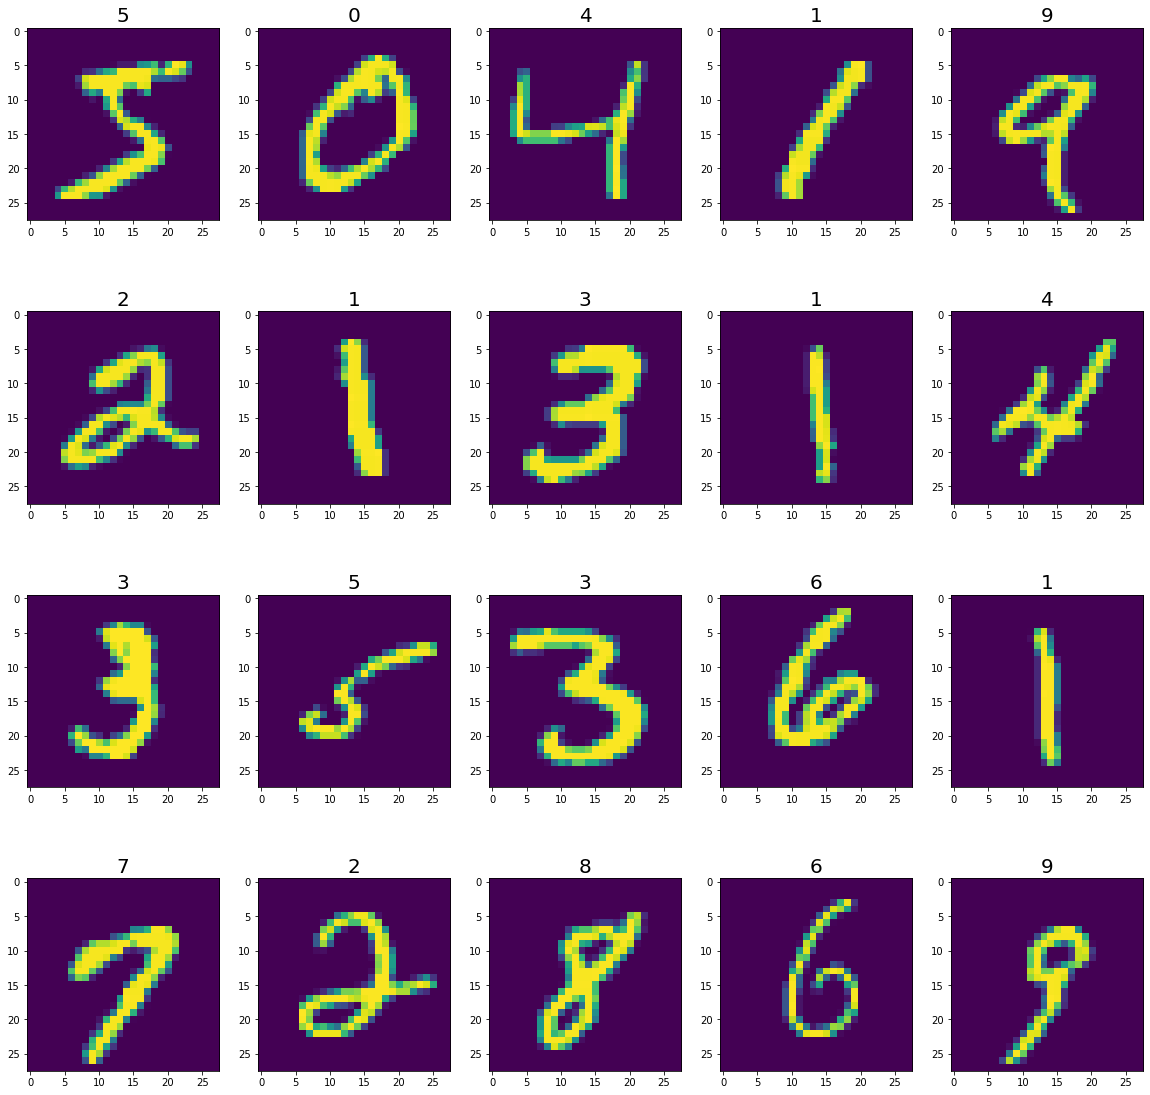

In [69]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
for i in range(20):
  plt.subplot(4, 5, i+1)
  plt.imshow(X_train[i])
  plt.title(np.argmax(y_train[i]), fontsize=20)

In [77]:
#VGG16 demands three channels for image so stacking the image in z-direction with same values

def to_rgb(img):
  img = cv2.resize(img, (32, 32))
  img_rgb = np.asarray(np.dstack((img, img, img)), dtype=np.float32)
  return img_rgb

X_train_rgb = []
X_test_rgb = []
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
#convert X_train data to 48x48 rgb values
for i in range(len(X_train)):
  img = to_rgb(X_train_copy[i])
  X_train_rgb.append(img)
for i in range(len(X_test)):
  img = to_rgb(X_test_copy[i])
  X_test_rgb.append(img)

    #print(rgb.shape)


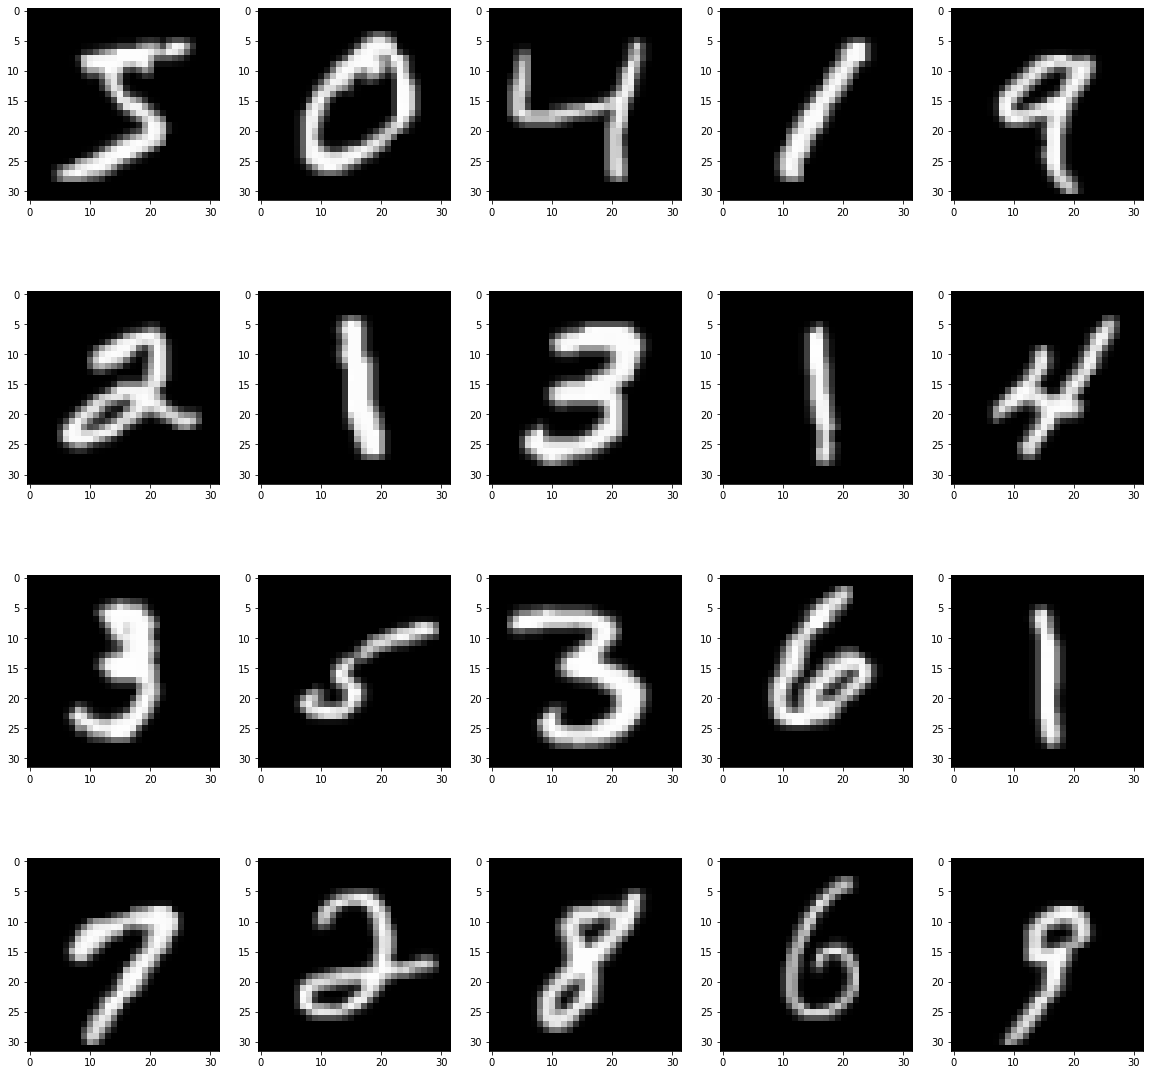

In [78]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
for i in range(20):
  plt.subplot(4, 5, i+1)
  plt.imshow(X_train_rgb[i])

In [81]:
X_train_rgb = np.asarray(X_train_rgb)
X_test_rgb = np.asarray(X_test_rgb)
X_train_rgb.shape

(60000, 32, 32, 3)

In [90]:
from keras.applications.vgg16 import VGG16
model = VGG16(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [87]:
type(model)

tensorflow.python.keras.engine.functional.Functional

In [91]:
features_x_train = model.predict(X_train_rgb)
features_x_test = model.predict(X_test_rgb)


In [95]:
type(features_x_train)

numpy.ndarray

In [96]:
features_x_train = features_x_train.reshape(-1, 512)
features_x_test = features_x_test.reshape(-1, 512)

In [115]:
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(features_x_train, y_train, test_size=0.1)
print(f'training images shape:\t{train_x.shape}\n')
print(f'training labels shape:\t{train_y.shape}\n')
print(20*'-')
print(f'training images shape:\t{valid_x.shape}\n')
print(f'training labels shape:\t{valid_y.shape}\n')

training images shape:	(54000, 512)

training labels shape:	(54000, 10)

--------------------
training images shape:	(6000, 512)

training labels shape:	(6000, 10)



In [116]:
train_x = train_x.reshape(54000, 512, 1)
valid_x = valid_x.reshape(6000, 512, 1)
train_x.shape

(54000, 512, 1)

In [122]:
valid_y[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [123]:
Model = tf.keras.Sequential()
#used kernel initializer to save time training the weights
#dropout layer to avoid overfitting probability and forcing the neural network to learn from data
#first set of layers
Model.add(Flatten(input_shape=(512, 1)))
Model.add(Dense(units=512, activation='relu', kernel_initializer='glorot_uniform'))
Model.add(Dropout(0.3))
#second set of layers
Model.add(Dense(units=1024, activation='relu', kernel_initializer='glorot_uniform'))
Model.add(Dropout(0.3))
#third set of layers
Model.add(Dense(units=256, activation='relu', kernel_initializer='glorot_uniform'))
Model.add(Dropout(0.3))

#output layer
Model.add(Dense(units=10, activation='softmax'))
Model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)              

In [125]:
Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = Model.fit(train_x,
                    train_y,
                    batch_size=32,
                    epochs=10,
                    validation_data=(valid_x, valid_y))

model.save('my_model.h5')

Epoch 1/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.1275 - accuracy: 0.9631 - val_loss: 0.1035 - val_accuracy: 0.9668
Epoch 2/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.1228 - accuracy: 0.9634 - val_loss: 0.1210 - val_accuracy: 0.9622
Epoch 3/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.1195 - accuracy: 0.9638 - val_loss: 0.1121 - val_accuracy: 0.9663
Epoch 4/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.1109 - accuracy: 0.9647 - val_loss: 0.1052 - val_accuracy: 0.9660
Epoch 5/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.1141 - accuracy: 0.9659 - val_loss: 0.1066 - val_accuracy: 0.9695
Epoch 6/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.1079 - accuracy: 0.9677 - val_loss: 0.1099 - val_accuracy: 0.9667
Epoch 7/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.1049 - accuracy: 0.9682 - val_loss: 0.0872 - val_accuracy:

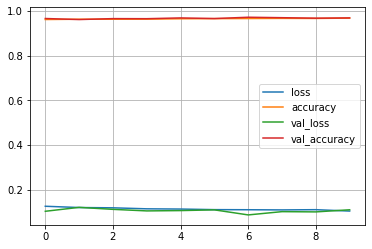

In [126]:
import pandas as pd
df = pd.DataFrame(history.history)
df.plot(grid=True)